#Yolo V5

##Importações

In [1]:
# !git clone https://github.com/IagoMagalhaes23/Pandora.git

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dropout, BatchNormalization

%cd ..
from utils import functions as fct

c:\Users\iagom\OneDrive\Desktop\Pands


##Carregando dados

In [2]:
caminho_train = 'dataset/recortado/train'
caminho_test = 'dataset/recortado/test'
caminho_valid = 'dataset/recortado/valid'

callback = EarlyStopping(monitor='loss', patience=5, mode='min')

data_train = fct.readFiles(caminho_train)
data_test= fct.readFiles(caminho_test)
data_valid = fct.readFiles(caminho_valid)

random.shuffle(data_train)
random.shuffle(data_test)
random.shuffle(data_valid)

df_train = pd.DataFrame(data_train, columns=['image', 'label'])
df_test = pd.DataFrame(data_test, columns=['image', 'label'])
df_valid = pd.DataFrame(data_valid, columns=['image', 'label'])

df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_valid = df_valid.reset_index(drop = True)

print('----------------------------- SHAPES DF -----------------------------')
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)
print('---------------------------------------------------------------------')

X_train, y_train = fct.compose_dataset(df_train)
X_test, y_test = fct.compose_dataset(df_test)
X_valid, y_valid = fct.compose_dataset(df_valid)

print('----------------------------- SHAPES LABEL -----------------------------')
print('Treino shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Valid shape: {}, Labels shape: {}'.format(X_valid.shape, y_valid.shape))
print('Teste shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('------------------------------------------------------------------------')

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)
datagen.fit(X_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

----------------------------- SHAPES DF -----------------------------
(169, 2)
(20, 2)
(20, 2)
---------------------------------------------------------------------
----------------------------- SHAPES LABEL -----------------------------
Treino shape: (169, 224, 224, 1), Labels shape: (169,)
Valid shape: (20, 224, 224, 1), Labels shape: (20,)
Teste shape: (20, 224, 224, 1), Labels shape: (20,)
------------------------------------------------------------------------


##Treinando modelo

In [11]:
def alexNet():
    '''
        Função com arquitetura da rede CNN AlexNet
        :return: modelo da rede CNN AlexNet
    '''
    model = Sequential()

    # Layer 1: Convolutional layer with 64 filters of size 11x11x3
    model.add(Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(224,224,1)))

    # Layer 2: Max pooling layer with pool size of 3x3
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 3-5: 3 more convolutional layers with similar structure as Layer 1
    model.add(Conv2D(filters=192, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

    # Layer 6: Fully connected layer with 4096 neurons
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    # Layer 7: Fully connected layer with 4096 neurons
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=5,activation="softmax"))

    optimizer = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    return model

modelAlex = alexNet()
history = modelAlex.fit(X_train, y_train, batch_size=1, epochs = 5, verbose = 1, callbacks=[callback])
modelAlex.summary()
modelAlex.save(filepath='alexnet.hdf5')

c:\Users\iagom\OneDrive\Desktop\Pands\env\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
169/169 [==============================] - 42s 231ms/step - loss: 0.1607 - accuracy: 0.1775
Epoch 2/5
169/169 [==============================] - 38s 226ms/step - loss: 0.1608 - accuracy: 0.2130
Epoch 3/5
169/169 [==============================] - 40s 234ms/step - loss: 0.1607 - accuracy: 0.2012
Epoch 4/5
169/169 [==============================] - 39s 229ms/step - loss: 0.1599 - accuracy: 0.2249
Epoch 5/5
169/169 [==============================] - 38s 225ms/step - loss: 0.1596 - accuracy: 0.1953
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 64)        7808      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2

c:\Users\iagom\OneDrive\Desktop\Pands\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Avaliando resultados

Avaliando resultados da rede CNN
Conjunto de treino
169/169 [==============================] - 6s 30ms/step
0.21301775147928995%
0.2%
0.04260355029585799%


c:\Users\iagom\OneDrive\Desktop\Pands\env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


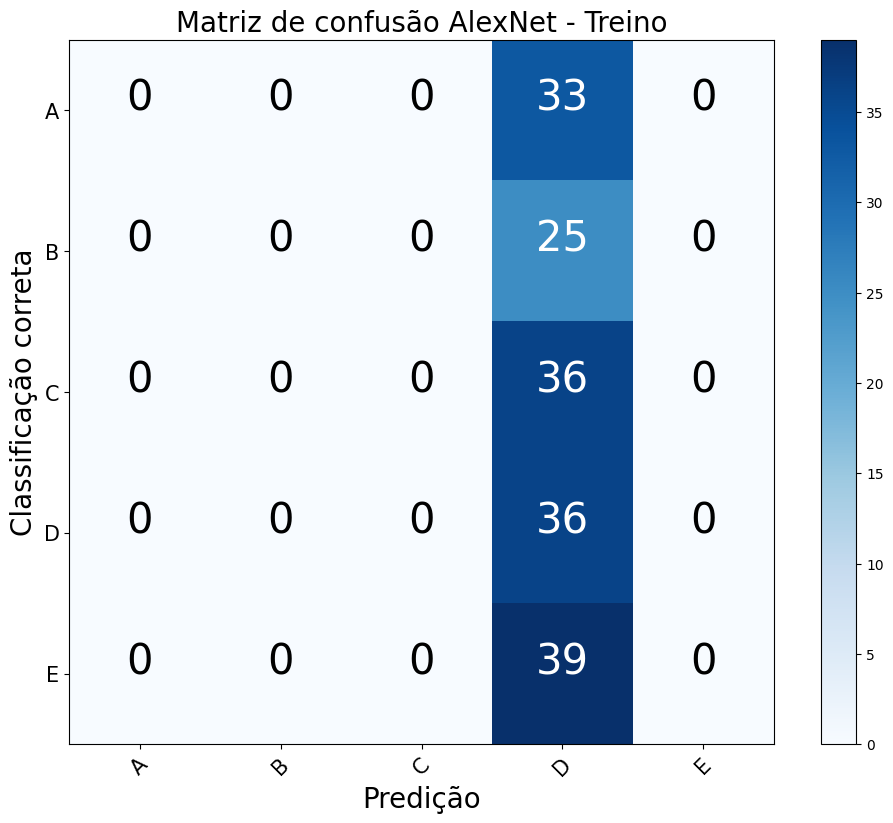

Conjunto de teste
20/20 [==============================] - 1s 31ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [8]:
# fct.plot_hist(history)

modelo = load_model('alexnet.hdf5')
print('Avaliando resultados da rede CNN')

print('Conjunto de treino')
y_pred = modelo.predict(X_train, batch_size=1)
y_pred=np.argmax(y_pred, axis=1)
y_train=np.argmax(y_train, axis=1)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

recall_macro = recall_score(y_train, y_pred, average='macro')
precision_macro = precision_score(y_train, y_pred, average='macro')
accuracy = accuracy_score(y_train, y_pred)
print('Acurácia: {}%'.format(accuracy))
print('Recall: {}%'.format(recall_macro))
print('Precisão: {}%'.format(precision_macro))

cmtrain = confusion_matrix(y_train, y_pred)
fct.plot_confusion_matrix(cm = cmtrain, normalize = False, target_names = ['A', 'B', 'C', 'D', 'E'], title = "Matriz de confusão AlexNet - Treino")
plt.show()

print('Conjunto de teste')
y_pred = modelo.predict(X_test, batch_size=1)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

recall_macro = recall_score(y_test, y_pred, average='macro')
precision_macro = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia: {}%'.format(accuracy))
print('Recall: {}%'.format(recall_macro))
print('Precisão: {}%'.format(precision_macro))

cmt = confusion_matrix(y_test, y_pred)
fct.plot_confusion_matrix(cm = cmt, normalize = False, target_names = ['A', 'B', 'C', 'D', 'E'], title = "Matriz de confusão AlexNet - Teste")
plt.show()

print('Conjunto de validação')
y_pred = modelo.predict(X_valid, batch_size=1)
y_pred=np.argmax(y_pred, axis=1)
y_valid=np.argmax(y_valid, axis=1)
# cm = confusion_matrix(y_valid, y_pred)
# print(cm)

recall_macro = recall_score(y_valid, y_pred, average='macro')
precision_macro = precision_score(y_valid, y_pred, average='macro')
accuracy = accuracy_score(y_valid, y_pred)
print('Acurácia: {}%'.format(accuracy))
print('Recall: {}%'.format(recall_macro))
print('Precisão: {}%'.format(precision_macro))

cmv = confusion_matrix(y_valid, y_pred)
fct.plot_confusion_matrix(cm = cmv, normalize = False, target_names = ['A', 'B', 'C', 'D', 'E'], title = "Matriz de confusão AlexNet - Validação")
plt.show()

##Realizando predições

1/1 [==============================] - 0s 59ms/step


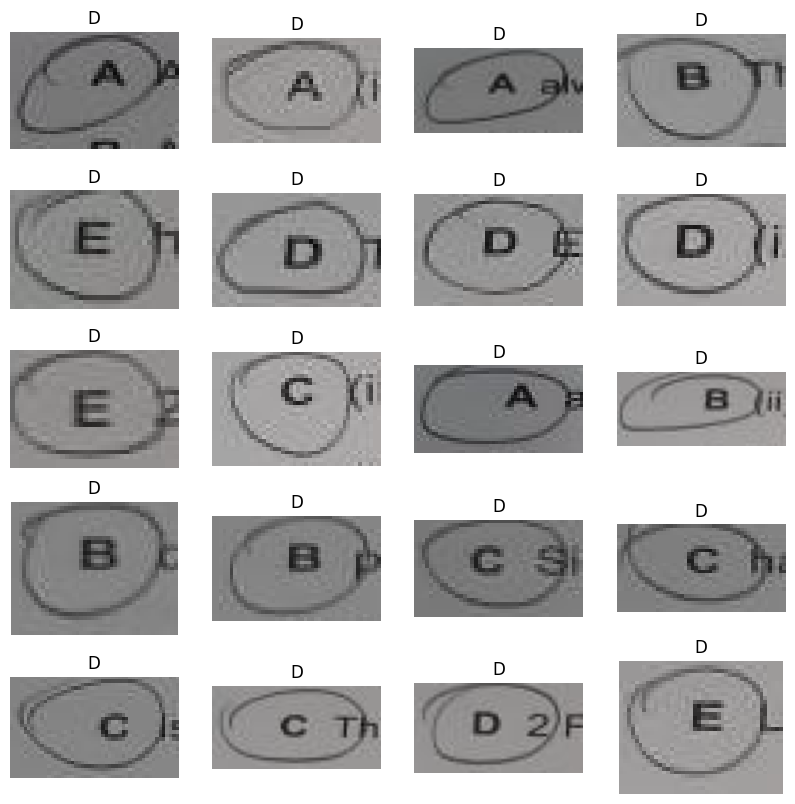

In [5]:
i = 1
fig=plt.figure(figsize=(10, 10))

dados = []
for caminho, _, arquivo in os.walk('dataset/recortado/valid'):
    caminho = str(caminho.replace("\\", "/"))
    for file in arquivo:
        dados.append(os.path.join(caminho + '/' + file[:-3] + 'png'))

for nome in dados:
    im = cv2.imread(nome)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    imres = cv2.resize(gray, (224, 224), interpolation=cv2.INTER_CUBIC)
    dados = fct.prepararImagem(imres)
    fig.add_subplot(5, 4, i)
    i = i + 1
    plt.imshow(im)
    plt.axis('off')
    ret = modelo.predict(dados, batch_size=1)
    plt.title(fct.mostraCateg(ret))
plt.show()